# News Mood

* On the average, BBC and CBS news media have a similar negative polarity, 0.85619 and 0.85570 repectively.  What drives BBC's compound polarity to 0.14 is the fact that it does have a high positive polarity and a very low neutral polarity which means that BBC more often takes a stand whether positive or negative on what they are reporting
* Fox News tends to take a high neutral stand.
* Based on the overall compound polarity, BBC New Media is the most positive media source (0.14) while CBS is the most negative media source (-0.08)

In [1]:
# Import and Initialize Sentiment Analyzer
# Dependencies
import tweepy
import json
import pytz
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
key_pd = pd.read_csv("Keys.py")
consumer_key = key_pd[key_pd['Name']== 'TW_consumer_key']['key'].max().strip()
consumer_secret = key_pd[key_pd['Name']== 'TW_consumer_secret']['key'].max().strip()
access_token = key_pd[key_pd['Name']== 'TW_access_token']['key'].max().strip()
access_token_secret = key_pd[key_pd['Name']== 'TW_access_token_secret']['key'].max().strip()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Target Accounts
target_accounts = ['BBC', 'CBSNews','CNN','FoxNews','NYTimes']
SourceName = ['BBC', 'CBS','CNN','Fox','New York Times']

# set limits
maxfollower = 2500
mintweets = 5
maxtweets = 10000
maxfollowing = 2500


tweet_sentiments = []

# Get 100 tweets from home feed
for src, target_account in zip(SourceName, target_accounts):
    # reset counter
    counter = 1
    try:
        public_tweets = api.user_timeline(target_account, count=100)
        for tweet in public_tweets:
            tweettext = tweet["text"]
            source = src
            target_string = tweettext


            # Run analysis
            compound = round(analyzer.polarity_scores(target_string)["compound"], 1)
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            
            # Store the Average Sentiments
            sentiment = {"Media Sources": source,
                 "Tweet Polarity": compound,
                 "Positive": pos,
                 "Negative": neu,
                 "Neutral": neg,
                 "Tweets Ago": counter } 

            # Print the Sentiments
            tweet_sentiments.append(sentiment) 
            counter += 1

        print("%s: %s" % (target_account, str(len(tweet_sentiments))))

    except:
        print("Error pulling data from %s page %s" % target_account, x)
                          
# create a DataFrame
tweet_sentiments_df = pd.DataFrame(tweet_sentiments) 

# sort, then reset index
tweet_sentiments_df = tweet_sentiments_df.sort_values('Tweets Ago', ascending = False).reset_index(drop=True)

tweet_sentiments_df.to_csv("Resources/MediaTweets_%s.csv" % datetime.today().strftime('%Y%m%d') )

tweet_sentiments_df.head()




BBC: 100
CBSNews: 200
CNN: 300
FoxNews: 400
NYTimes: 500


,Media Sources,Negative,Neutral,Positive,Tweet Polarity,Tweets Ago
0,New York Times,1.000,0.000,0.000,0.0,100
1,Fox,0.839,0.000,0.161,0.3,100
2,BBC,0.566,0.149,0.285,0.6,100
3,CNN,1.000,0.000,0.000,0.0,100
4,CBS,0.830,0.170,0.000,-0.6,100


In [2]:
sentiment_group = tweet_sentiments_df.groupby('Media Sources').aggregate({'Negative':'mean', 'Positive':'mean', 'Neutral':'mean', 'Tweets Ago': 'max'})
sentiment_group


,Negative,Positive,Neutral,Tweets Ago
Media Sources,,,,
BBC,0.85619,0.09670,0.04710,100
CBS,0.85570,0.06064,0.08366,100
CNN,0.84210,0.08607,0.07185,100
Fox,0.82205,0.07989,0.09800,100
New York Times,0.84110,0.07000,0.08890,100


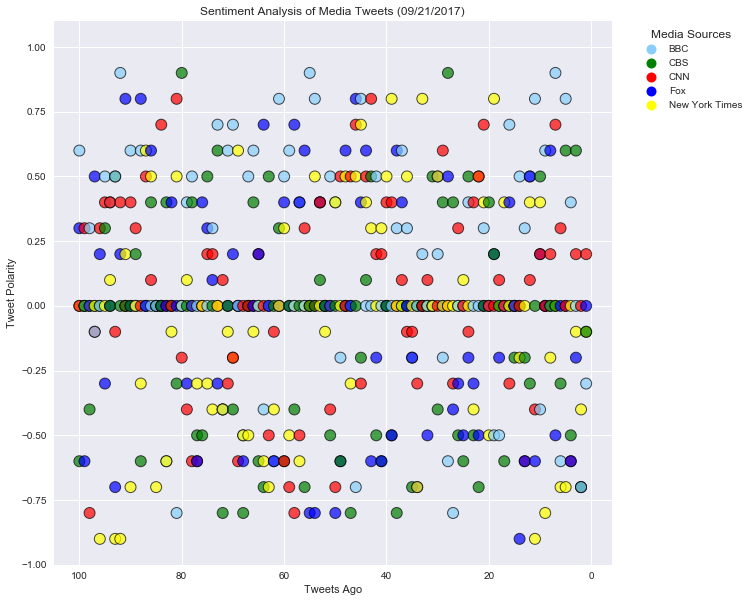

In [3]:
from matplotlib.lines import Line2D as Line2D

colors=['lightskyblue', 'green', 'red', 'blue', 'yellow']
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(tweet_sentiments_df['Tweets Ago'],tweet_sentiments_df['Tweet Polarity'],  s=120, marker="o", facecolor=tweet_sentiments_df["Media Sources"].map({SourceName[0]: colors[0], SourceName[1]: colors[1],SourceName[2]: colors[2],SourceName[3]: colors[3],SourceName[4]: colors[4]}), alpha=0.7, edgecolors="black", linewidth=1) 

# create patches
patches = []
for s, c in zip(SourceName, colors):
    patches.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c, label=s))
    

plt.legend(handles=patches, frameon=False, title="Media Sources", loc="upper right", bbox_to_anchor=(1.25,1))
    
ax.grid(True)
ax.set_title('Sentiment Analysis of Media Tweets (%s)' % datetime.today().strftime('%m/%d/%Y'))
ax.set_xlabel('Tweets Ago')
ax.set_ylabel('Tweet Polarity')
ax.set_xlim(tweet_sentiments_df['Tweets Ago'].max()+5, tweet_sentiments_df['Tweets Ago'].min()-5)
ax.set_ylim(-1, 1.1)

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig("Sentiment_Analysis_%s.png" % datetime.today().strftime('%Y%m%d'), bbox_inches='tight')

In [4]:
averagePolarity = []
for src in SourceName:
    averagePolarity.append(round(tweet_sentiments_df[tweet_sentiments_df['Media Sources'] == src]['Tweet Polarity'].mean(), 2))
averagePolarity_df = pd.DataFrame(averagePolarity, columns=['Tweet Polarity'])
averagePolarity_df.fillna(0, inplace=True)
averagePolarity_df

,Tweet Polarity
0,0.14
1,-0.08
2,0.04
3,-0.03
4,-0.04


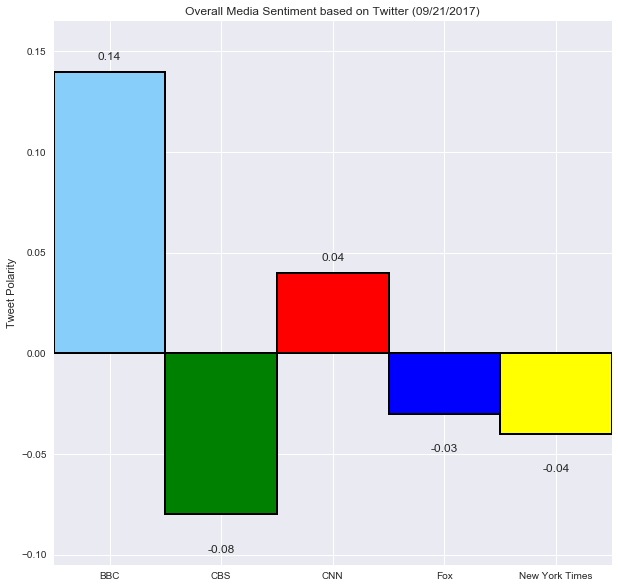

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

x_axis = np.arange(0, len(SourceName))   
rects = ax.bar(x_axis, averagePolarity_df['Tweet Polarity'], width=1, color=colors, edgecolor="black", linewidth=2, align="center")

for rect, label in zip(rects, averagePolarity_df['Tweet Polarity']):
    if (label > 0):
        labely = +0.005
    else:
        labely = -0.020
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+labely, label,     
    ha='center', va='bottom')

ax.set_xticks(x_axis)
ax.set_ylabel("Tweet Polarity")
ax.set_xticklabels(SourceName, rotation=0)
ax.set_xlim(-0.5, len(x_axis)-.5)
ax.set_ylim(averagePolarity_df['Tweet Polarity'].min()-.025, averagePolarity_df['Tweet Polarity'].max()+0.025)
ax.set_title("Overall Media Sentiment based on Twitter (%s)" % datetime.today().strftime('%m/%d/%Y'))

fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig("Overall_Media_Sentiment_%s.png" % datetime.today().strftime('%Y%m%d'), bbox_inches='tight')